In [2]:
from groq import Groq
    
client = Groq(api_key='<your_API_KEY')

def send_request(system, prompt):
	# input message written by user
	message = [
		{"role": "system", "content": system}, 
		{"role": "user", "content": prompt}
	]

	chat_completion = client.chat.completions.create(
		messages=message,
		model="llama3-70b-8192",
		temperature=0.7,
		max_tokens=2048,
		stream=True,
		stop=None,
		top_p=0.8
	)

	# Accumulate the chunks of the response
	response_text = ""
	for chunk in chat_completion:
		response_text += chunk.choices[0].delta.content or ""

	response_data = {
		"response": response_text
	}

	return response_data['response']

### pre-cached clustering

In [4]:
import pandas as pd

df_games = pd.read_parquet('files/games.parquet')
df_games['Tags'] = df_games['Tags'].apply(lambda x : x.split(','))
# df_games['Genres'] = df_games['Genres'].apply(lambda x : x.split(','))
df_games = df_games.drop(['game_vector', 'game_indices', 'Score', 'Recommendations'], axis=1)
df_games

,index,Name,Release date,Estimated owners,Peak CCU,Price,About the game,Total_reviews,Genres,Tags
0,0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,19.99,Galactic Bowling is an exaggerated and stylize...,17,"Casual,Indie,Sports","[Indie, Casual, Sports, Bowling]"
1,1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0.99,THE LAW!! Looks to be a showdown atop a train....,58,"Action,Indie","[Indie, Action, Pixel Graphics, 2D, Retro, Arc..."
2,6,TD Worlds,"Jan 9, 2022",0 - 20000,3,10.99,"TD Worlds is a dynamic, highly strategical gam...",28,"Indie,Strategy","[Tower Defense, Rogue-lite, RTS, Replay Value,..."
3,8,MazM: Jekyll and Hyde,"Apr 2, 2020",0 - 20000,1,14.99,'MazM: Jekyll and Hyde' is a darkly entertaini...,82,"Adventure,RPG,Simulation,Strategy","[Adventure, Simulation, RPG, Strategy, Singlep..."
4,9,Deadlings: Rotten Edition,"Nov 11, 2014",50000 - 100000,0,3.99,Death is lonely. He has zero friends on his Fa...,270,"Action,Adventure,Indie","[Action, Indie, Adventure, Puzzle-Platformer, ..."
...,...,...,...,...,...,...,...,...,...,...
41931,85065,Drop Doll,"Jan 5, 2024",0 - 20000,0,1.79,Game Introduction: 'Drop Doll' is a casual puz...,28,"Casual,Early Access","[Mature, Sexual Content, Casual, Relaxing, NSF..."
41932,85077,Ant Farm Simulator,"Jan 5, 2024",0 - 20000,3,0.99,Ant Farm (formicarium) With A Colony Of Ants. ...,2,"Casual,Indie,Simulation,Early Access","[Simulation, Casual, Sandbox, Farming Sim, Lif..."
41933,85079,The Holyburn Witches,"Jan 5, 2024",0 - 20000,0,2.99,"In the once tranquil village of Holyburn, Main...",4,"Casual,Indie,Early Access","[Casual, Adventure, Point & Click, Exploration..."
41934,85083,Digital Girlfriend,"Jan 5, 2024",0 - 20000,0,3.74,《Digital Girlfriend》 is a nurturing game of su...,15,"Adventure,Casual,Indie","[Casual, Sexual Content, Nudity, Adventure, Ma..."


In [ ]:
# if we were to choose to encode our data using a pre-trained encoder
# (you can replace the co-occurence Matrix relatioship by running this code)

# from sentence_transformers import SentenceTransformer
# from tqdm import tqdm
# tqdm.pandas()

# # we instatiate the model first, so we can assign it to multiple copies of the engine
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device='cpu')

# tags_set = set()
# [[tags_set.add(tag) for tag in sample] for sample in df_games['Tags'].values.tolist()]

# df_raw = pd.DataFrame(sorted(tags_set), columns=['tags'])
# df_raw['vector_tags'] = df_raw['tags'].apply(lambda x : model.encode(x))
# df_raw

,tags,vector_tags
0,1980s,"[-0.034906115, 0.11030235, 0.0038526154, 0.030..."
1,1990's,"[-0.055882152, 0.04985953, -0.017577216, 0.011..."
2,2.5D,"[-0.014469616, -0.010294223, 0.10194698, 0.008..."
3,2D,"[0.036877517, -0.0131612625, -0.026026763, -0...."
4,2D Fighter,"[-0.013568571, 0.065569684, -0.08865826, 0.011..."
...,...,...
441,World War I,"[-0.051502924, 0.044791527, -0.015061613, 0.00..."
442,World War II,"[-0.031718876, 0.082735814, -0.0749105, 0.0292..."
443,Wrestling,"[-0.01779714, 0.027195442, -0.009485713, 0.045..."
444,Zombies,"[-0.037441406, 0.070383266, -0.076504104, 0.01..."


In [34]:
import pandas as pd

# use relationships extracted from a co-occurrence matrix
df_raw = pd.read_parquet('files/M.parquet')
df = pd.DataFrame([df_raw.values.tolist()]).T
df.insert(0, 'tags', df_raw.index)
df.columns = ['tags', 'vector_tags']
df_raw = df

In [35]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

id2t3 = {x[0]:x[1] for x in enumerate(df_raw['tags'])}
df_raw['tags'] = df_raw.index
relationships = pd.DataFrame(df_raw['vector_tags'].tolist()).values

# Convert to a pandas DataFrame for easier manipulation
tags = df_raw.tags.tolist()
df_rel = pd.DataFrame(relationships, index=tags)

def compute_linkage_matrix(df_rel):
	distance_matrix = 1 - (df_rel / df_rel.max()).values # are there other variations?
	linkage_matrix = linkage(distance_matrix, method='ward', metric='euclidean', optimal_ordering=True) # there is no randomic element
	return linkage_matrix

def visualize_dendrogram(linkage_matrix, color_threshold):
	plt.figure(figsize=(18, 6))
	dendrogram(linkage_matrix, labels=tags, leaf_rotation=90, leaf_font_size=4, color_threshold=color_threshold)
	plt.title('Tag Hierarchy')
	plt.xlabel('Distance')
	plt.ylabel('Tags')
	plt.show()

linkage_matrix = compute_linkage_matrix(df_rel)

C:\Users\ardit\AppData\Local\Temp\ipykernel_39720\4005755062.py:16: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward', metric='euclidean', optimal_ordering=True) # there is no randomic element


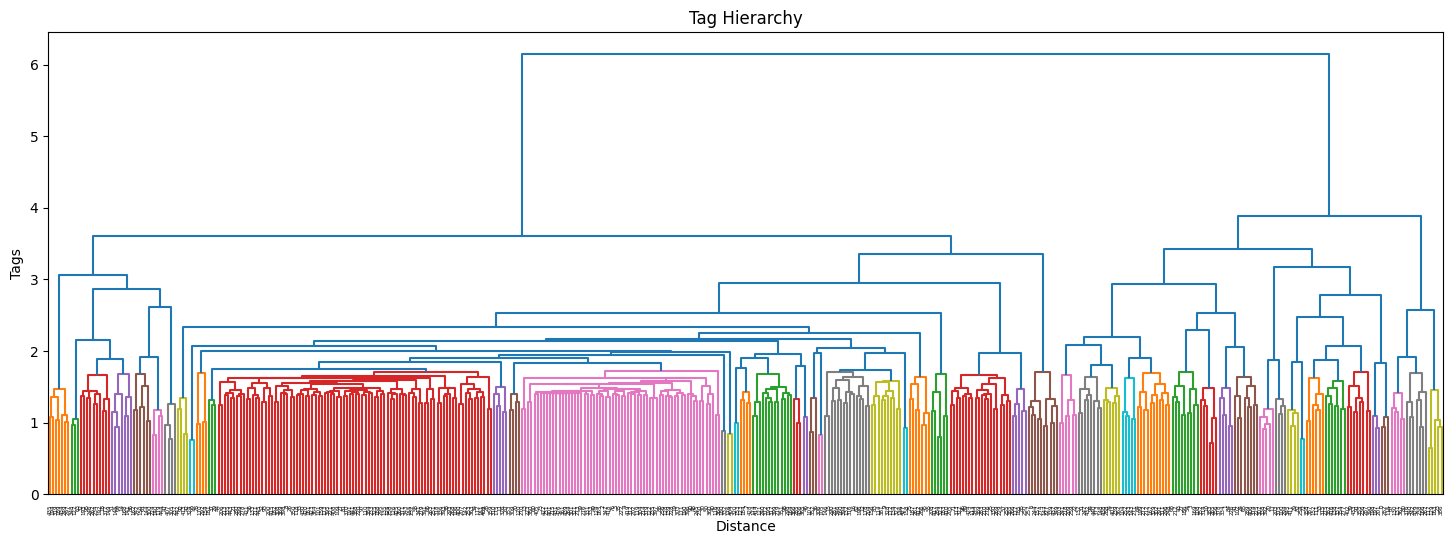

In [36]:
visualize_dendrogram(linkage_matrix, 1.74)

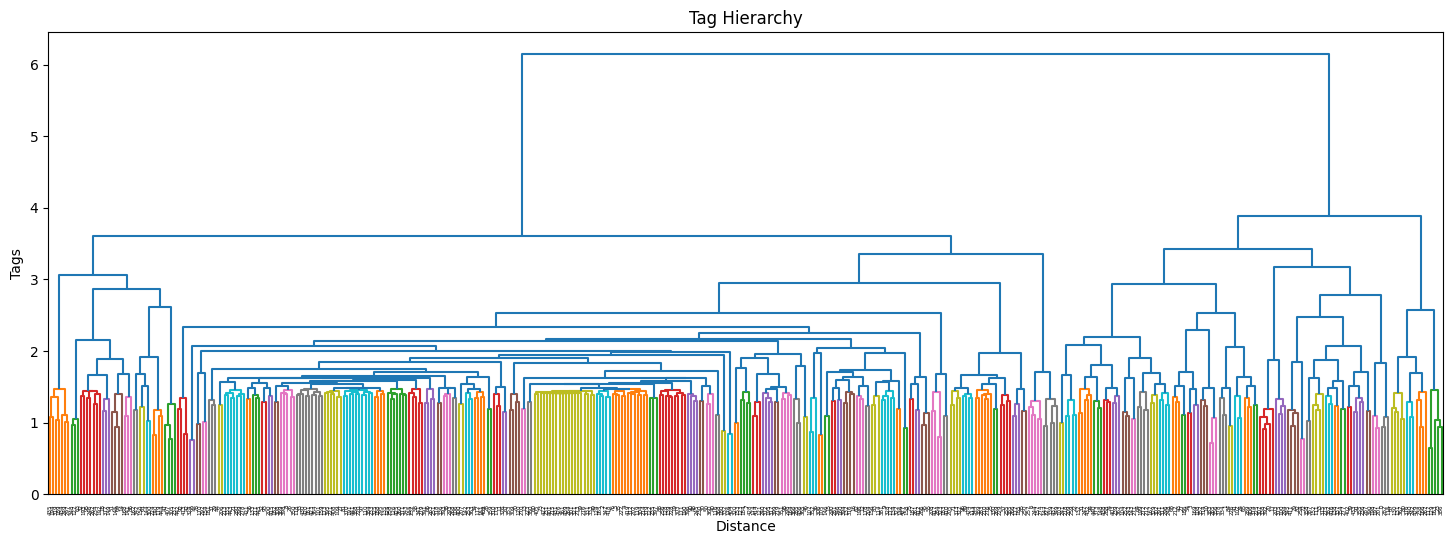

In [37]:
visualize_dendrogram(linkage_matrix, 1.47)

In [58]:
# decide n_clusters
def print_statement(label_n):
	print(f'label_{label_n}:', df[f'label_{label_n}'].max())
	display(df.value_counts(f'label_{label_n}')[0:10])
      
df = pd.DataFrame(df_rel.index, columns=['label_3'])

# add clusters
layers_list = list()
layers_list.append(fcluster(linkage_matrix, 1.7, criterion='distance'))
layers_list.append(fcluster(linkage_matrix, 1.47, criterion='distance'))
for layer in range(0, len(layers_list)):
    df.insert(layer, f'label_{layer+1}', layers_list[layer]-1)
df.to_csv('files/df_full.csv', index=None)
df

,label_1,label_2,label_3
0,55,123,0
1,44,105,1
2,15,44,2
3,42,101,3
4,15,45,4
...,...,...,...
441,11,26,441
442,7,11,442
443,11,17,443
444,5,9,444


In [60]:
# show distribution
print_statement(1)
print_statement(2)

label_1: 58


label_1
11    77
15    62
32    20
27    13
21    13
40    11
12    11
2     10
28    10
37     8
Name: count, dtype: int64

label_2: 127


label_2
43    20
45    12
26    10
47     9
24     9
28     7
2      7
17     7
0      7
81     6
Name: count, dtype: int64

### super-cluster labeling

In [43]:
import time

def compute_tags(df, tag_lists, layer, verbose=False, max_retries=5):

	new_tags = list()
	for g in df.groupby([f'label_{layer}']):
		df_ = g[1]
		time.sleep(1)
		
		tag_dictionary = tag_lists[layer]
		counter = 0
		new_tag = ''
		while counter < max_retries:
			try:
				cluster_n = df_[f'label_{layer}'].tolist()[0]
				tag_list = [tag_dictionary[tag] for tag in df_[f'label_{layer+1}'].tolist()]

				response = send_request(
					system="you are a valid assistant",
					prompt=f"""\
					Given the following tags:
					{tag_list}

					Output **a single NEW hihg-level tag** to define the group (output it after GROUP_TAG:), dont add your comments
					GROUP_TAG:
					"""
				)
				new_tag = response.split('TAG:')[1].strip()
				if verbose : print(layer, cluster_n, '\t', new_tag, '<-', tag_list)
				break
			except Exception as e:
				if verbose : print(counter, e)
				counter + 1

		new_tags.append([cluster_n, new_tag])

	# add dictionary to tag lists
	new_tags = pd.DataFrame(new_tags, columns=['cluster_n', 'new_tag'])
	tag_lists[layer-1] = dict(new_tags.values)

	return new_tags, tag_lists

# we store the tag list of the last layer
tag_lists = [0, 0, id2t3]

# for layer in range(len(df.columns)-1, 0, -1):
# 	new_tags, tag_lists = compute_tags(df, tag_lists=tag_lists, layer=layer, verbose=True, max_retries=5)
# 	new_tags.to_csv(f'new_tags_{layer}.csv', index=None)

### recommender function

In [45]:
import warnings
warnings.filterwarnings('ignore')

# load tag lists back
tag_lists = [0, 0, id2t3]
for layer in range(len(df.columns)-1, 0, -1):
	# print(layer)
	dict_tags = dict(pd.read_csv(f'files/new_tags_{layer}.csv').values)
	tag_lists[layer-1] = dict_tags
sample_tags = [*tag_lists[-1].values()]

# full dataframe
df = pd.read_csv('df_full.csv')

# labeled dataframe
df_labeled = df.copy()
df_labeled = df_labeled.sort_values([*df_labeled.columns])
for layer in range(1, len(df_labeled.columns)+1):
    df_labeled[f'label_{layer}'] = df_labeled[f'label_{layer}'].apply(lambda x : tag_lists[layer-1][x])
# correct duplicate LLM labels
tag_lists[0][41] = 'Dark Action'
df_labeled[0:15]

# create index dict
tag2index = {tag_lists[2][value]:value for index, value in enumerate(tag_lists[2])}

In [46]:
from tqdm import tqdm

def encode(input_tags):
    vector = np.zeros(len(tag_lists[-1]))
    indexes = [tag2index[x] for x in input_tags]
    for index in indexes:
        vector[index] = 1
    return vector

# extract raw lists
sample_list = df_games['Tags'].values.tolist()

sample_vectors = list()
for sample in tqdm(sample_list, desc="processing samples"):
	sample_vectors.append(encode(sample))
     
sample_vectors = np.array(sample_vectors)

processing samples: 100%|██████████| 41936/41936 [00:00<00:00, 149619.46it/s]


In [47]:
#compute multipliers
tag_stats = dict()
tag_frequency = dict()
tag_frequency_labeled = dict()
for tag in sample_tags:
	tag_count = len([sample for sample in sample_list if tag in sample])
	sample_count = len(sample_list)
	freq_inv_score = tag_count/sample_count
	tag_index = tag2index[tag]
	tag_frequency[tag_index] = freq_inv_score
	tag_frequency_labeled[tag] = freq_inv_score
	# tag_frequency[tag_index] = 1/len(engine.tag_list)
	# tag_frequency_labeled[tag] = 1/len(engine.tag_list)

# show label score given frequency
df_frequency_labeled = pd.DataFrame([[tag_frequency_labeled[x], x] for x in tag_frequency_labeled])
df_frequency_labeled.columns = ['score', 'tag']
df_frequency_labeled.sort_values('score', ascending=False)[0:10]

for g in df.groupby('label_1'):
	df_ = g[1]
	indexes = df_['label_3'].values
	scores = [tag_frequency[index] for index in indexes]
	cluster_score = (1/len(df['label_1'].unique()))/sum(scores)
	new_scores = [cluster_score for x in scores]
	# new_scores = [min(2.5, x) for x in new_scores]
	# new_scores = [max(0.1, x) for x in new_scores]

	# mean_n_cluster = df['label_1'].value_counts().mean() # if I use max, it creates gigantic values
	for val in list(zip(indexes, new_scores)):
		index = val[0]
		score = val[1] #* mean_n_cluster/len(indexes)
		tag_frequency[index] = score
		tag_frequency_labeled[tag_lists[2][index]] = score

# we are going to use the matrix to adapt vector weights
M_frequency = np.array([*tag_frequency.values()])

### testing sequential recommender

In [48]:
# after every ingestion we diminish the score of existing vectors
def update_vector(historical_vector, cached_vector, ingestion_n, decay_rate):
	# adjust the score of the historical vector
	multiplier = (decay_rate)**ingestion_n
	historical_vector *= multiplier

	# add to cached vectr
	historical_vector = historical_vector + cached_vector

	# TODO : purge vector
	return historical_vector

def user_choices(choices, cap=1):
	choices_flatten = [x for xs in choices for x in xs]
	vector = encode(choices_flatten)
	vector = np.array(vector) * M_frequency
	vector = np.where(vector > cap, cap, vector)
	vector = np.array(vector)
	return vector

def compute_recommendation(historical_vector, label_1_max=3):
	df_hist = pd.concat([df, pd.Series(historical_vector)], axis=1)
	top1 = df_hist.groupby(['label_1']).sum().sort_values(0, ascending=False)[0:label_1_max].index
	df_hist_ = df_hist[df_hist['label_1'].isin(top1)]
	df_hist_ = df_hist_.groupby(['label_1', 'label_2', 'label_3']).sum().reset_index()
	df_hist_['label_1'] = df_hist_['label_1'].apply(lambda x : tag_lists[0][x])
	df_hist_['label_2'] = df_hist_['label_2'].apply(lambda x : tag_lists[1][x])
	df_hist_['label_3'] = df_hist_['label_3'].apply(lambda x : tag_lists[2][x])
	return df_hist_

import plotly.express as px
from collections import Counter
import pandas as pd

def plot_sim_freq(results):
	# Flatten the list of samples
	flat_samples = [item for sublist in results for item in sublist]

	# Count the frequency of each sample
	frequency = Counter(flat_samples)

	# Convert the frequency to a pandas DataFrame
	df = pd.DataFrame(list(frequency.items()), columns=['cluster', 'frequency'])
	df = df.sort_values('frequency', ascending=False)

	# Plot the distribution using plotly
	fig = px.bar(df, x='cluster', y='frequency')
	fig.show()

In [50]:
import random

# if no vector exists, the first choices are the historical vector
historical_vector = user_choices(choices=[['Shooter', 'Fantasy']])

# day1
cached_vector = user_choices(choices=[['Puzzle-Platformer'], ['Dark Fantasy'], ['Fantasy']])
historical_vector = update_vector(historical_vector, cached_vector, 1, 0.8)

# # day2
cached_vector = user_choices(choices=[['Puzzle'], ['Puzzle-Platformer']])
historical_vector = update_vector(historical_vector, cached_vector, 1, 0.8)

# day2
cached_vector = user_choices(choices=[['Adventure'], ['2D', 'Turn-Based']])
historical_vector = update_vector(historical_vector, cached_vector, 1, 0.8)

compute_recommendation(historical_vector, label_1_max=3)

,label_1,label_2,label_3,0
0,Strategy,Turn-Based Games,Turn-Based Tactics,0.000000
1,Strategy,Turn-Based Games,Turn-Based Combat,0.000000
2,Strategy,Turn-Based Games,Turn-Based Strategy,0.000000
3,Strategy,Turn-Based Games,Turn-Based,0.119801
4,Action,Action,Precision Platformer,0.000000
5,Action,Action,Parkour,0.000000
6,Action,Action,Runner,0.000000
7,Action,Action-Adventure,3D Platformer,0.000000
8,Action,Action-Adventure,Physics,0.000000
9,Action,Action-Adventure,Puzzle-Platformer,0.143874


In [56]:
for day in range(100):
	r = random.randint(3, 7)
	cached_vector = user_choices(random.choices(sample_list, k=r))
	historical_vector = update_vector(historical_vector, cached_vector, 1, 0.5)
compute_recommendation(historical_vector, label_1_max=3)

,label_1,label_2,label_3,0
0,Mastermind,Strategy,Tactical,4.721973e-02
1,Mastermind,Strategy,Wargame,2.194554e-11
2,Mastermind,Strategy,Military,4.715071e-02
3,Mastermind,Strategy,War,1.062447e-01
4,Mastermind,Strategy,Tower Defense,1.189063e-05
5,Mastermind,Strategy,Real Time Tactics,9.426686e-02
6,Mastermind,Strategy,RTS,9.245356e-05
7,Social,Multiplayer,Competitive,5.337748e-05
8,Social,Multiplayer,PvP,2.187027e-01
9,Social,Multiplayer,Team-Based,2.186875e-01


### validation

In [176]:
import random

# using tag_frequency
def sims():
	historical_vector = user_choices(random.choices(sample_list, k=5))
	for day in range(100):
		r = random.randint(3, 7)
		cached_vector = user_choices(random.choices(sample_list, k=r))
		historical_vector = update_vector(historical_vector, cached_vector, 1, 0.5)
	results = compute_recommendation(historical_vector, label_1_max=5)
	return results['label_1'].unique().tolist()

results = list()
for s in range(10000):
	s_results = sims()
	results.append(s_results)

plot_sim_freq(results)

In [173]:
# count cluster frequency from sample sampling
k = 20000
res_list = list()
random_samples = random.choices(sample_list, k=k)
random_samples = [item for sublist in random_samples for item in sublist]
# random_samples becomes all the individual tags extracted from our choices
for chosen_tag in random_samples:
	cluster = df_labeled[df_labeled['label_3']==chosen_tag]['label_1'].tolist()[0]
	# apply multiplier
	chosen_tag_score = tag_frequency_labeled[chosen_tag]
	res_list.append([cluster, chosen_tag_score])

target_uniform = 1/len(df['label_1'].unique())
df_freq = pd.DataFrame(res_list).value_counts()
df_freq = df_freq.reset_index()
# df_freq.columns = ['']
df_freq['count'] = df_freq['count']
df_freq['freq'] = df_freq[1]*df_freq['count']/k
df_freq['diff'] = df_freq['freq']-target_uniform
df_freq[0:10]

,0,1,count,freq,diff
0,Extremely Fun,0.006852,49411,0.016928,-0.000021
1,Epic Quest,0.025694,13124,0.016861,-0.000089
2,Retro Action Challenge,0.027018,12287,0.016598,-0.000351
3,Whimsical Humor,0.028421,11735,0.016676,-0.000273
4,Immersive Action,0.028752,11615,0.016698,-0.000251
5,Classic Platformer,0.029185,11570,0.016884,-0.000065
6,Fantasy Action Games,0.032888,10213,0.016794,-0.000155
7,Entertainment,0.037323,9077,0.016939,-0.000010
8,Exploration-based Survival,0.042276,7966,0.016838,-0.000111
9,Virtual Worlds,0.044283,7571,0.016763,-0.000186


In [174]:
import plotly.express as px
import pandas as pd

df_values = df_freq[[0, 'freq']]
fig = px.bar(df_values, x=0, y='freq')
fig.show()
# vertically stacked values are caused by label_1 clusters with duplicate names

<Axes: >

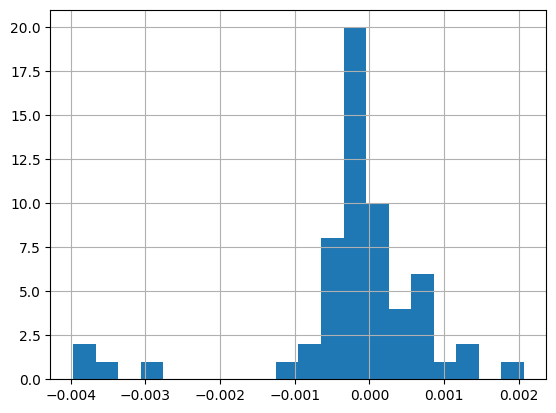

In [175]:
df_freq['diff'].hist(bins=20)